In [1]:
import joblib
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sentence_transformers import SentenceTransformer
import sys
import os

sys.path.append(os.path.abspath('..'))
project_root = os.path.dirname(os.path.dirname(os.path.abspath('.')))
if project_root not in sys.path:
    sys.path.append(project_root)

from train.classifier import data_loader, model as model_def, config as classifier_config
from src.logger import logger
from src import config as main_config

sns.set_style('whitegrid')

e:\agentic-reasoning-engine\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
try:
    # Load the artifact
    model_path = os.path.join(classifier_config.MODEL_OUTPUT_DIR, classifier_config.MODEL_NAME)
    artifact = joblib.load(model_path)
    logger.info(f"Loaded model artifact from {model_path}")

    # Extract components
    model_state_dict = artifact['model_state_dict']
    label_encoder = artifact['label_encoder']
    input_dim = artifact['input_dim']
    num_classes = artifact['num_classes']

    # Initialize model architecture and load state
    device = "cuda" if torch.cuda.is_available() else "cpu"
    classifier_model = model_def.SimpleClassifierNN(input_dim=input_dim, num_classes=num_classes).to(device)
    classifier_model.load_state_dict(model_state_dict)
    classifier_model.eval()
    logger.info("Classifier model is ready.")

    # Load the sentence transformer for inference
    embedding_model = SentenceTransformer(main_config.EMBEDDING_MODEL_NAME)
    logger.info(f"Sentence transformer '{main_config.EMBEDDING_MODEL_NAME}' is ready.")

except FileNotFoundError as e:
    logger.error(f"Error: {e}. Please run the training script first.")

2025-10-07 22:19:17,386 - AgenticReasoningPipeline - INFO - Loaded model artifact from e:\agentic-reasoning-engine\models\problem_classifier.pkl (2917370375.py:5)
2025-10-07 22:19:17,391 - AgenticReasoningPipeline - INFO - Classifier model is ready. (2917370375.py:18)
2025-10-07 22:19:21,825 - AgenticReasoningPipeline - INFO - Sentence transformer 'all-MiniLM-L6-v2' is ready. (2917370375.py:22)


In [3]:
# Get the validation dataloader
_, val_loader, _ = data_loader.get_dataloaders()

y_true = []
y_pred = []

with torch.no_grad():
    for embeddings, labels in val_loader:
        embeddings, labels = embeddings.to(device), labels.to(device)
        outputs = classifier_model(embeddings)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

print("--- Classification Report (Validation Set) ---")
report = classification_report(y_true, y_pred, target_names=label_encoder.classes_)
print(report)

2025-10-07 22:19:40,444 - AgenticReasoningPipeline - INFO - Loading data for classifier training... (data_loader.py:22)
2025-10-07 22:19:40,459 - AgenticReasoningPipeline - INFO - Data loading complete. Train size: 307, Val size: 77 (data_loader.py:45)
--- Classification Report (Validation Set) ---
                                      precision    recall  f1-score   support

                     Classic riddles       0.67      0.29      0.40         7
                    Lateral thinking       0.55      0.86      0.67         7
                       Logical traps       0.00      0.00      0.00         2
             Operation of mechanisms       0.93      1.00      0.96        13
Optimization of actions and planning       1.00      0.94      0.97        17
                    Sequence solving       1.00      1.00      1.00        12
                   Spatial reasoning       0.90      1.00      0.95        19

                            accuracy                           0.88       

e:\agentic-reasoning-engine\venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
e:\agentic-reasoning-engine\venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
e:\agentic-reasoning-engine\venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


--- Confusion Matrix (Validation Set) ---


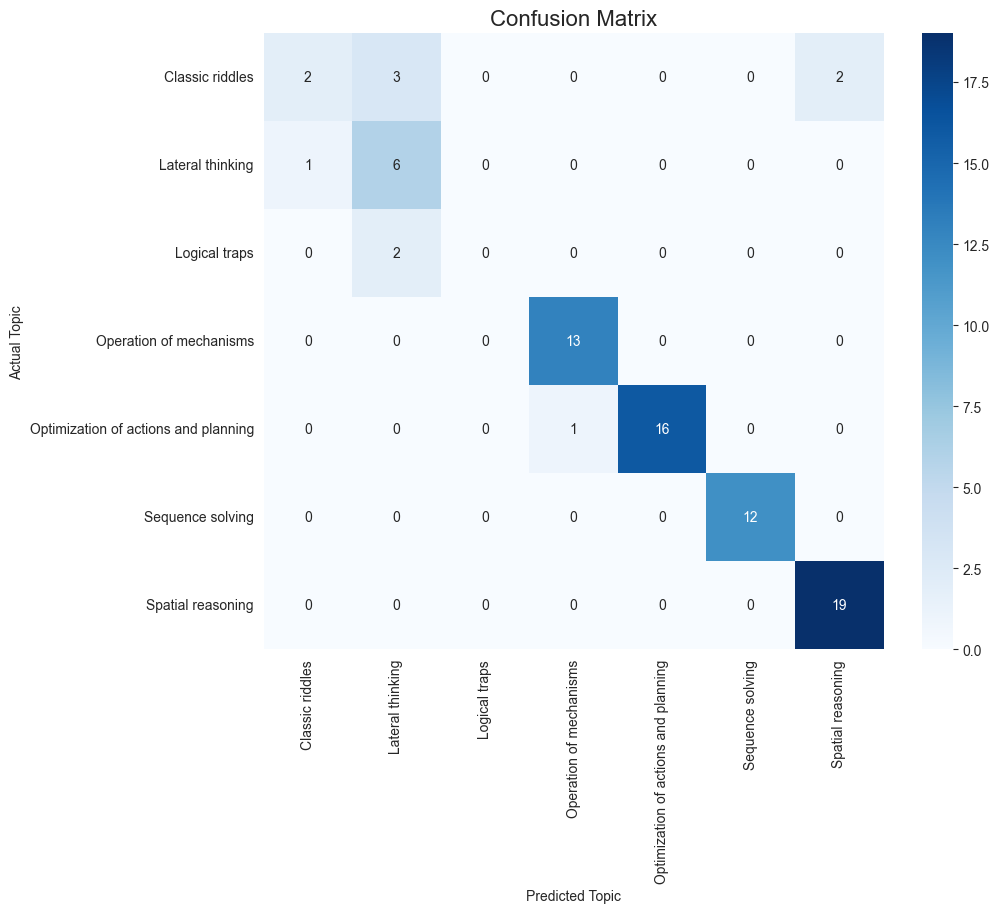

In [4]:
print("--- Confusion Matrix (Validation Set) ---")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('Actual Topic')
plt.xlabel('Predicted Topic')
plt.show()

In [5]:
def classify_problem(text: str):
    """Takes raw text, creates an embedding, and returns the predicted topic."""
    # Create embedding
    embedding = embedding_model.encode([text], convert_to_tensor=True).to(device)
    
    with torch.no_grad():
        output = classifier_model(embedding)
        _, predicted_idx = torch.max(output.data, 1)
        
    # Decode the predicted index to its topic name
    predicted_topic = label_encoder.inverse_transform([predicted_idx.item()])
    return predicted_topic[0]

In [7]:
# Load the test JSON to get some sample problems
test_df = pd.read_json(f"{main_config.PROCESSED_DATA_DIR}/test_processed.json")

# Extract first 5 problem statements for testing
sample_problems = test_df['problem_statement'].head(5).tolist()

print("--- Running Inference on 5 Samples from Test Set ---")
for i, problem in enumerate(sample_problems):
    predicted_topic = classify_problem(problem)
    print(f"\n{i+1}. PROBLEM: '{problem[:100]}...'")
    print(f"   -> PREDICTED TOPIC: {predicted_topic}")

--- Running Inference on 5 Samples from Test Set ---

1. PROBLEM: 'You have four rods of different lengths: 8 cm, 5 cm, 12 cm, and 3 cm. You must create a three-dimens...'
   -> PREDICTED TOPIC: Spatial reasoning

2. PROBLEM: 'A woman shoots her husband. Then she holds him underwater for five minutes. Finally, she hangs him. ...'
   -> PREDICTED TOPIC: Lateral thinking

3. PROBLEM: 'You are in a race and you overtake the second person. What position are you in now?...'
   -> PREDICTED TOPIC: Classic riddles

4. PROBLEM: 'In a factory, there are three machines A, B, and C. Machine A polishes items, Machine B engraves the...'
   -> PREDICTED TOPIC: Operation of mechanisms

5. PROBLEM: 'You have three seemingly identical machines, each with a single button on top. One of the machines i...'
   -> PREDICTED TOPIC: Operation of mechanisms


In [8]:
def classify_problem_with_confidence(text: str, top_k=3):
    """Classifies problem and returns top K predictions with confidence scores."""
    # Create embedding
    embedding = embedding_model.encode([text], convert_to_tensor=True).to(device)
    
    with torch.no_grad():
        output = classifier_model(embedding)
        probabilities = torch.softmax(output, dim=1)
        top_probs, top_indices = torch.topk(probabilities, top_k)
        
    # Get topic names and confidence scores
    results = []
    for prob, idx in zip(top_probs[0], top_indices[0]):
        topic = label_encoder.inverse_transform([idx.item()])[0]
        results.append({
            'topic': topic,
            'confidence': prob.item()
        })
    
    return results

print("\n--- Enhanced Inference with Confidence Scores ---")
for i, problem in enumerate(sample_problems):
    predictions = classify_problem_with_confidence(problem, top_k=2)
    print(f"\n{i+1}. PROBLEM: '{problem[:80]}...'")
    for j, pred in enumerate(predictions):
        print(f"   {j+1}. {pred['topic']}: {pred['confidence']:.3f}")


--- Enhanced Inference with Confidence Scores ---

1. PROBLEM: 'You have four rods of different lengths: 8 cm, 5 cm, 12 cm, and 3 cm. You must c...'
   1. Spatial reasoning: 0.998
   2. Classic riddles: 0.001

2. PROBLEM: 'A woman shoots her husband. Then she holds him underwater for five minutes. Fina...'
   1. Lateral thinking: 0.776
   2. Classic riddles: 0.171

3. PROBLEM: 'You are in a race and you overtake the second person. What position are you in n...'
   1. Classic riddles: 0.406
   2. Logical traps: 0.209

4. PROBLEM: 'In a factory, there are three machines A, B, and C. Machine A polishes items, Ma...'
   1. Operation of mechanisms: 0.893
   2. Optimization of actions and planning: 0.100

5. PROBLEM: 'You have three seemingly identical machines, each with a single button on top. O...'
   1. Operation of mechanisms: 0.999
   2. Spatial reasoning: 0.001


In [9]:
# Calculate additional performance metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("\n--- Performance Summary ---")
print(f"Overall Accuracy: {accuracy:.4f}")
print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")
print(f"Weighted F1-Score: {f1:.4f}")
print(f"Number of Classes: {num_classes}")
print(f"Validation Samples: {len(y_true)}")

# Per-class accuracy
from sklearn.metrics import accuracy_score
class_accuracy = []
for class_idx in range(num_classes):
    class_mask = np.array(y_true) == class_idx
    if np.sum(class_mask) > 0:
        class_acc = accuracy_score(
            np.array(y_true)[class_mask], 
            np.array(y_pred)[class_mask]
        )
        class_accuracy.append((label_encoder.classes_[class_idx], class_acc))

print("\n--- Per-Class Accuracy ---")
for topic, acc in sorted(class_accuracy, key=lambda x: x[1], reverse=True):
    print(f"{topic}: {acc:.4f}")


--- Performance Summary ---
Overall Accuracy: 0.8831
Weighted Precision: 0.8668
Weighted Recall: 0.8831
Weighted F1-Score: 0.8639
Number of Classes: 7
Validation Samples: 77

--- Per-Class Accuracy ---
Operation of mechanisms: 1.0000
Sequence solving: 1.0000
Spatial reasoning: 1.0000
Optimization of actions and planning: 0.9412
Lateral thinking: 0.8571
Classic riddles: 0.2857
Logical traps: 0.0000


e:\agentic-reasoning-engine\venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
